# Introduction
Welcome to our second set of hands-on exercise! In this notebook we'll be implementing two common explainability methods: SHAP and LIME. Let's get started!

# Part One: SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. SHAP values interpret the impact of a particular value for a given feature on the prediction, relative to a baseline value of that feature.

You can find the original paper about the SHAP package [here](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf).

SHAP values break down a prediction to show the impact of each feature. This lab is based on Scott Lundberg's [SHAP Demo](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html). We'll be explaining a sentiment analysis model using SHAP.

**Discuss:** When do you think SHAP explanations would be useful? Can you think of some specific examples?

## Setup

In [ ]:
# Required installations
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.39.0-cp38-cp38-linux_x86_64.whl size=538380 sha256=ea378680c4d6ff311102df9fa98427a51f73e7b49230815ea8cc6ed82e94a079
  Stored in directory: /root/.cache/pip/wheels/3d/c9/06/734ed80d6d61fad331974bf62017b4ea6b33488082b9f5e67e
Successfully built shap


In [ ]:
# Import the required modules
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
shap.initjs()

### Load and preprocess the data
The dataset we use is the classic IMDB dataset from [this paper](https://www.aclweb.org/anthology/P11-1015/). It consists of movie reviews and our task is to predict whether the review is positive or negative. 

In [ ]:
# Load the data
corpus, y = shap.datasets.imdb()

# Take a look at the first example and its corresponding class (True if review is positive, False if review is negative)
print('Class:', y[0])
corpus[0]

Class: False


"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

Note that our data in this case is just text. We'll need to do some preprocessing to get it into numerical format so that we can build a model with it (that we can the get SHAP values for!). Preprocessing text data is a huge area within Natural Language Processing (NLP) that is beyond the scope of this particular notebook, but [here](https://exchange.scale.com/public/blogs/preprocessing-techniques-in-nlp-a-guide) is a great resource to start learning more.

Before preprocessing our data, let's split it into train and test sets.   
**Discuss:** why is it important to split into train and test sets? why do we do this before our preprocessing?

In [ ]:
# Split into train and test sets
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

The most intuitive way to transform text into numbers would be to simply count how many times each word occurs in each text. We could represent each document as a vector of word counts, where each element of the vector corresponds to one word in our vocabulary.

For example, consider a corpus of the following documents:
- "The rat ate the pizza."
- "The pizza is delicious."
- "The cats are fluffy."

We have 9 words in the vocabulary: ['ate', 'are', 'cats', 'delicious', 'fluffy', 'is', 'pizza', 'rat', 'the']. We could represent the first document as [1, 0, 0, 0, 0, 0, 1, 1, 2]. 

This method is called Bag of Words, and while it is straightforward, it has some shortcomings. **Can you think of any?**

Instead, we're going to use the [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from sklearn. TF-IDF stands for "term frequency - inverse document frequency." In its simplest form, for each word (term) $i$ in each document $j$, we calculate the TF-DF value $w_{i,j}$ as:

<img src="https://miro.medium.com/max/638/1*Uucq42G4ntPGJKzI84b3aA.png" />

We represent each document as a vector of the TF-IDF values for each word. Using the example above, the first document would be represented as [0.47, 0, 0, 0, 0, 0, 0.17, 0.47, 0].

The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Here, the ```TfidfVectorizor``` will make this transformation for us. 

**Discuss: what is min_df? What are we `fitting' here?**

In [ ]:
# Fit vectorizer on training data, then transform both the training and test data
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

## Build logistic regression model

In [ ]:
## here we're using scikit learn to build our model
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
## note Penalized logistic regression imposes a penalty to the logistic model for having too many variables. 
## This results in shrinking the coefficients of the less contributive variables toward zero. This is also known as regularization
## A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. 

LogisticRegression(C=0.1)

In [ ]:
# Evaluate our classifier's performance
sklearn.metrics.accuracy_score(model.predict(X_test), y_test)

0.8476

## Explain the model with SHAP
We need to create an **explainer** object in SHAP. The type of SHAP explainer we use will be determined by the sort of model that we trained. Because we trained logistic regression model, which is from sklearn.linear_model, we'll want to use a LinearExplainer. See other options [here](https://shap.readthedocs.io/en/latest/#). 

In [ ]:
# Initialize the explainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


### Summary Plot
We can use summary_plot to summarize the most important features. 

**What are we looking at in this graph?**
- Each dot is an example in the test set
- The color of each dot tells us about the magnitude of the feature -- that is, the magnitude of the TF-IDF value for that word in that document: low (blue) to high (red)
- The SHAP value tells us the contribution of that feature to each prediction

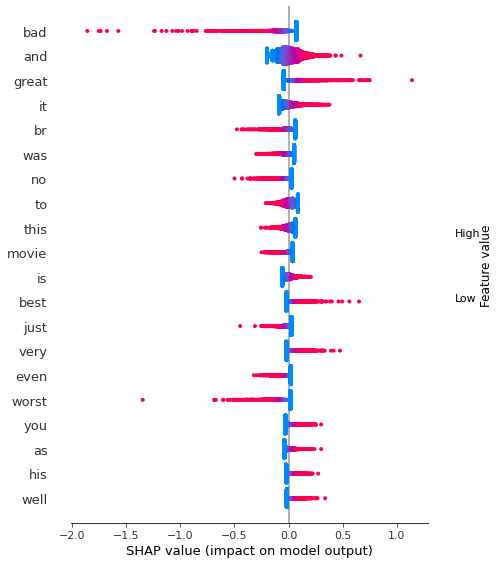

In [ ]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

**Discuss:** 
- Do these SHAP values largely make sense? 
- What order are these words in? What determines which words we're seeing in this visualization?
- Why are the dots for the token "and" so tightly clustered?

### Dependence Plots
Dependence plots let us zoom in on a single feature and see how its 1) importance and 2) relationship to the outcome vary across its range. Let's look at the word "bad"; first, we figure out which feature it is in our vectorizer.

In [ ]:
## get feature number
print(np.where(vectorizer.get_feature_names_out()=='bad')[0])

[1283]


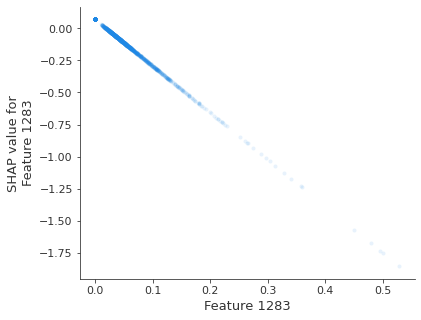

In [ ]:
shap.dependence_plot(1283, shap_values, X_test_array, alpha=0.1, interaction_index=None)
## note: alpha makes the points transparent so it is easier to see the density

Let's try "great"

In [ ]:
## get feature number
print(np.where(vectorizer.get_feature_names_out()=='great')[0])

[6530]


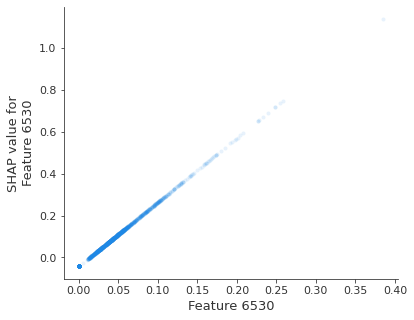

In [ ]:
shap.dependence_plot(6530, shap_values, X_test_array, alpha=0.1, interaction_index=None)

We can also color the plot by the relationship between two features. For example, we might expect the word "enjoyable" to have a lower SHAP value in texts where we also see the word "not"...

In [ ]:
## get feature numbers
print(np.where(vectorizer.get_feature_names_out()=='enjoyable'))
print(np.where(vectorizer.get_feature_names_out()=='not'))

(array([5047]),)
(array([10035]),)


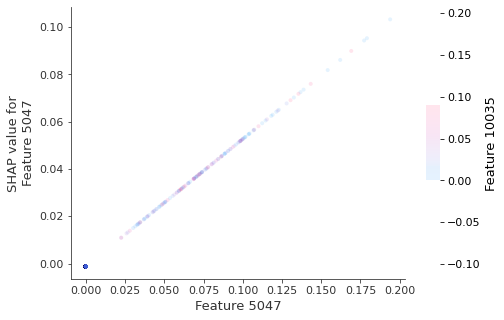

In [ ]:
shap.dependence_plot(5047, shap_values, X_test_array, alpha=0.1, interaction_index=10035)

**Discuss:** what does this tell us about how much we should trust the SHAP interpretation for the word "enjoyable" for this model?

Next, let's look at the explanation for a single review. Here, we decompose a prediction with the following equation:

> sum(SHAP values for all features) = pred_for_review - pred_for_baseline_values

The SHAP values of all features sum up to explain why the prediction was different from the baseline.

In [ ]:
shap.initjs()
idx = 7
print("Positive" if y_test[idx] else "Negative", "Review:")
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Negative Review:
this one of the best celebrity's reality shows a ever saw. we can see the concerts we can see the life of Britney, i love the five episodes. i was always being surprised by Britney and the subjects of the show i think that some people don't watch the show at all we can how a great person she his. she his really funny really gentle and she loves her fans and we can see how she loves her work. i just don't give a 10 because of k-fed he his a real jerk he doesn't seem to like Britney at all. I they make a second season of this great show because it shows at some people how Britney really is. Go Britney your the best and you will never leave our hearts.



Our SHAP value based prediction for review 7 is 1.29, whereas the base_value is -0.1842. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. In this example, the biggest impacts come from the features "great" and "best" which are strongly positive. We can also see there are more features pushing this review in the positive prediction direction.

Next, let's identify the all the features that contribute to the positive and negative classification this review

In [ ]:
# Checking the words that contribute to the positive and negative classification of document 7
idx = 7
vals = shap_values[idx,:]
positive_sentiment_weight = defaultdict(float)
negative_sentiment_weight = defaultdict(float)
feats = vectorizer.get_feature_names_out()

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_sentiment_weight[feat_i] += val_i
  elif val_i < 0:
    negative_sentiment_weight[feat_i] += val_i

In [ ]:
# print top positively contributing words
list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[:10]

[('great', 0.210045996108043),
 ('best', 0.14733915265571626),
 ('shows', 0.07878672524123624),
 ('see', 0.07518528701165061),
 ('love', 0.07146021651095044),
 ('bad', 0.07051523697015553),
 ('his', 0.06706719452400685),
 ('show', 0.06671278441915987),
 ('to', 0.06626035154595622),
 ('br', 0.0599546687360962)]

In [ ]:
# print top negatively contributing words
list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1)))[:10]

[('it', -0.061794022077312834),
 ('don', -0.05908686457242382),
 ('at', -0.041746960899776774),
 ('is', -0.04167638107915184),
 ('and', -0.04078398715505485),
 ('as', -0.03937013217491583),
 ('in', -0.03805699621584043),
 ('make', -0.03326321040859884),
 ('doesn', -0.02775211885127747),
 ('because', -0.023319810413261408)]

**Discuss:** What do you think about these explanations? How much would you trust them if you had no domain knowledge of the data/problem you were modeling? What are some limitations you see with this method?

Before moving on, let's take a look at a great [summary](https://towardsdatascience.com/using-shap-for-explainability-understand-these-limitations-first-1bed91c9d21) of some of the main limitations of SHAP. 